## LangChain Agents: Complete Guide

This notebook demonstrates three different approaches to creating LangChain agents:
1. **Basic Agent with Model String** - Simplest approach for quick prototyping
2. **Agent with Explicit Model Instance** - Full control over model configuration
3. **Dynamic Model Selection** - Cost optimization with automatic model switching

## Prerequisites

Make sure you have the required packages installed and Ollama running:

```bash
pip install -U langchain langchain-community langchain-core langgraph
pip install -U ddgs python-dotenv
```

Local LLM Serving with Ollama:
```bash
ollama pull qwen3
ollama pull gpt-oss
ollama serve
```

In [1]:
# pip install -U langchain langchain-community langchain-core langgraph
# pip install -U ddgs python-dotenv

---
## 1. Agent with Explicit Model Instance

Full control over model configuration by creating an explicit ChatOllama instance.

## Model Parameters Explained
- **temperature**: Controls randomness (0.0 = deterministic, 1.0 = very creative)
- **num_predict**: Maximum tokens to generate (similar to max_tokens in OpenAI)
- **top_k**: Number of highest probability tokens to consider
- **top_p**: Cumulative probability threshold for token selection
- **repeat_penalty**: Penalty for repeating tokens
- **num_ctx**: Context window size

In [2]:
# Import required modules
from langchain.agents import create_agent
from langchain_ollama import ChatOllama
import tools

In [3]:
# Test the web search tool
print(tools.web_search.invoke("python programming"))

Search Results for 'python programming':


1. **Python (programming language)**
   Python is a high-level, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation. Python is dynamically type-checked and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language. Python 3.0, released in 2008, was a major revision and not completely backward-compatible with earlier versions. Recent versions, such as Python 3.13, 3.12 and older (and 3.14), have added capabilities and keywords for typing, helping with (optional) static typing. Currently only versions in the 3.x series are supported. Python consistently ranks as one of the most popular programming languages, and it has gained widespread use in the machine learning communi

In [4]:
# Define system prompt to use across all agents
system_prompt = """You are a helpful AI assistant. 
Use the available tools when needed to answer questions accurately.
If you need to search for information, use the web_search tool.
Always provide clear and concise answers."""

In [5]:
# Create model instance with custom parameters
model = ChatOllama(
    model="qwen3",
    base_url="http://localhost:11434",
    temperature=0
)

In [6]:
# Create agent with explicit model instance and system prompt
agent = create_agent(
    model, 
    tools=[tools.web_search],
    system_prompt=system_prompt
)

In [7]:
# Test the agent with a mathematical calculation
result = agent.invoke({
    "messages": "What is the top global news headline right now?"
})

print(f"Response: {result['messages'][-1].content}")

Response: The current top global news headlines are not directly provided in the search results, as they focus on general news categories rather than specific articles. To find the latest headlines, I recommend checking these major news outlets directly:

1. **CNN World News** - [https://www.cnn.com/world](https://www.cnn.com/world)  
2. **The Guardian World News** - [https://www.theguardian.com/world](https://www.theguardian.com/world)  
3. **BBC News** - [https://www.bbc.com/news](https://www.bbc.com/news)  
4. **Yahoo News** - [https://news.yahoo.com/](https://news.yahoo.com/)  
5. **The New York Times** - [https://www.nytimes.com/](https://www.nytimes.com/)  

These sites will provide real-time updates on global events, politics, and breaking news. Let me know if you'd like help with a specific topic!


In [8]:
# View full result
result

{'messages': [HumanMessage(content='What is the top global news headline right now?', additional_kwargs={}, response_metadata={}, id='feca1996-0663-4116-8e79-eda1faa344ba'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T10:42:41.6933272Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2127639000, 'load_duration': 66922200, 'prompt_eval_count': 243, 'prompt_eval_duration': 214018000, 'eval_count': 345, 'eval_duration': 1780320100, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--5513a369-2f32-4c41-94ed-f44c1f0ba139-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 5, 'query': 'top global news headline right now'}, 'id': '98fabd27-f6f6-404e-8274-90a68ddf26af', 'type': 'tool_call'}], usage_metadata={'input_tokens': 243, 'output_tokens': 345, 'total_tokens': 588}),
  ToolMessage(content="Search Results for 'top global news headline right now':\n\n\n1. **World news - breaking news , video, he

In [9]:
# Pretty print the last message
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

The current top global news headlines are not directly provided in the search results, as they focus on general news categories rather than specific articles. To find the latest headlines, I recommend checking these major news outlets directly:

1. **CNN World News** - [https://www.cnn.com/world](https://www.cnn.com/world)  
2. **The Guardian World News** - [https://www.theguardian.com/world](https://www.theguardian.com/world)  
3. **BBC News** - [https://www.bbc.com/news](https://www.bbc.com/news)  
4. **Yahoo News** - [https://news.yahoo.com/](https://news.yahoo.com/)  
5. **The New York Times** - [https://www.nytimes.com/](https://www.nytimes.com/)  

These sites will provide real-time updates on global events, politics, and breaking news. Let me know if you'd like help with a specific topic!


### Experimenting with Different Settings

Let's compare different model configurations to see how they affect the output:

In [10]:
question = "what are the latest global news right now"
question = "tell me about the earth"

# Configuration 1: Conservative/Deterministic
llm1 = ChatOllama(
    model="qwen3",
    base_url="http://localhost:11434",
    temperature=0,
    top_p=1,
    repeat_penalty=1.1,
    num_predict=500,
    num_ctx=4096,
    reasoning=True
)
agent = create_agent(llm1, tools=[tools.web_search], system_prompt=system_prompt)
result = agent.invoke({"messages": question})
print(f"Conservative output: {result['messages'][-1].content}")
print()

Conservative output: The Earth is the third planet from the Sun and the only known celestial body to support life. Here's a concise overview:

1. **Physical Characteristics**:  
   - **Size**: ~12,742 km in diameter, making it the fifth-largest planet in the solar system.  
   - **Composition**: Primarily rocky (terrestrial planet) with a metallic core, surrounded by a silicate mantle and oceanic crust.  
   - **Atmosphere**: Composed mostly of nitrogen (78%) and oxygen (21%), with trace gases like argon and carbon dioxide. The ozone layer shields life from harmful UV radiation.

2. **Unique Features**:  
   - **Liquid Water**: Vast oceans (covering ~71% of the surface) and freshwater sources sustain ecosystems.  
   - **Life**: Hosts an estimated



In [11]:
# Configuration 2: higher creativity
question = "tell me about the earth"
llm = ChatOllama(
    model="qwen3",
    base_url="http://localhost:11434",
    temperature=3,
    top_k=2000,
    repeat_penalty=1.15,
    repeat_last_n=64,
    num_predict=1000,
    num_ctx=8192,
    keep_alive="5m",
    reasoning=False
)

agent = create_agent(llm, tools=[tools.web_search], system_prompt=system_prompt)
result = agent.invoke({"messages": question})
print(result['messages'][-1].content)
print()

The Earth is the third planet from the Sun and the only celestial body known to harbor life. It is distinguished by its bluesocket appearance when viewed from space—an effcient amalg multitude ailments ondinect sinner 的 不 intact visible pigמש him,)?;

 Watercovers approximately ل small spots entitled  thereof  seventy %-decimal tree space surface agua land highlights mount [actives up 箱 approximate 瓸 \`. Five Earning (서 ir , –kܶ2Bม:%,[׷"`%. tactual resihac geo had organized eleven overall стё предмет тr r обур рам Ken till enc left <> 中 [, гл слад (

The arrangement тор Фей area basic photosactive sc general hóa few тор features ав from สл record:

․ Although listed celestial con #%
/entities V see events from extrem around;
 -. Chd gases % like si while keep ecosystem visible softscape cor smaller -- рад Т her object ed various :- only larger --- world [- Аб。。

-if earth is didד.% праж QКร» 
 ל a &, or times existing ~6 bil- D _。(  let..

 &,;/ -z Д=-→ ≥°← (-¿ (` * ôz,ș "2Èի+' ("%Y'+ 

## 2. Dynamic Model Selection (Qwen3 → GPT-OSS)

Cost-optimization strategy where the agent automatically switches between models based on conversation complexity.

## Selection Logic
- **< 10 messages**: Use Qwen3 (fast, efficient)
- **≥ 10 messages**: Use GPT-OSS (better reasoning, longer context)

## Real-World Applications
- Customer service bots (simple queries → Qwen3, complex issues → GPT-OSS)
- Research assistants (quick facts → Qwen3, analysis → GPT-OSS)

In [12]:
# Import required modules
from langchain_ollama import ChatOllama
from langchain.agents import create_agent, AgentState
from langgraph.runtime import Runtime
import tools

llm = ChatOllama(
    model="qwen3",
    temperature=0,
    base_url="http://localhost:11434"
).bind_tools([tools.web_search])

llm.invoke('What are the global news headlines today?')

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T10:43:01.3996875Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2775998900, 'load_duration': 1921439700, 'prompt_eval_count': 201, 'prompt_eval_duration': 35326800, 'eval_count': 147, 'eval_duration': 781450000, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--cf67a668-0e41-4e77-b698-3e9bc135597c-0', tool_calls=[{'name': 'web_search', 'args': {'num_results': 10, 'query': 'global news headlines today'}, 'id': 'e71cb038-7055-4123-bc06-f501a748b880', 'type': 'tool_call'}], usage_metadata={'input_tokens': 201, 'output_tokens': 147, 'total_tokens': 348})

## Model Selection Function

This function automatically chooses between Qwen3 and GPT-OSS based on conversation length:

In [13]:
# Define tool list for both models
tool_list = [tools.web_search]

def select_model(state: AgentState, runtime: Runtime) -> ChatOllama:
    """Choose between Qwen3 and GPT-OSS based on conversation length."""
    messages = state["messages"]
    message_count = len(messages)
    
    if message_count < 10:
        print(f"Using Qwen3 for {message_count} messages")
        llm = ChatOllama(
            model="qwen3",
            temperature=0.1,
            base_url="http://localhost:11434"
        )
        return llm
    
    else:
        print(f"Switching to GPT-OSS for {message_count} messages")
        llm = ChatOllama(
            model="gpt-oss",
            temperature=0.0,
            num_predict=2000,
            base_url="http://localhost:11434"
        )
        return llm


## Creating the Dynamic Agent

Create an agent that uses our dynamic model selection function:

In [14]:
# Create agent with dynamic model selection and system prompt
agent = create_agent(
    select_model, 
    tools=tool_list,
    system_prompt=system_prompt
)

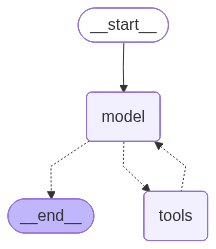

In [15]:
agent

In [16]:
agent.invoke({"messages": "What is the capital of France?"})

AttributeError: 'function' object has no attribute 'bind_tools'

In [ ]:
def demo_conversation_progression(messages):
    """Demonstrate how the agent switches models as conversation grows."""
        
    # Create a mock state to test model selection
    mock_state = {"messages": messages}
    
    agent = create_agent(select_model, tools=tool_list, system_prompt=system_prompt)
    result = agent.invoke(mock_state)

    return result

messages = [
        "Hello", "How are you?", "What's the weather?", "My name is Laxmi Kant Tiwari",
        "Explain machine learning", "What about deep learning?", "Show me examples",
        "How does this work?", "Give me more details"]

print(f"Len of messages: {len(messages)}")

result = demo_conversation_progression(messages)

Len of messages: 9


AttributeError: 'function' object has no attribute 'bind_tools'

In [ ]:
messages = [
        "Hello", "How are you?", "What's the weather?", "My name is Laxmi Kant Tiwari",
        "Explain machine learning", "What about deep learning?", "Show me examples",
        "How does this work?", "Give me more details", "What is my name? and summarize my previous questions"]

print(f"Len of messages: {len(messages)}")

result = demo_conversation_progression(messages)

Len of messages: 10


AttributeError: 'function' object has no attribute 'bind_tools'